In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

[]


In [2]:
# Start by importing the bq_helper module and calling on the specific active_project and dataset_name for the BigQuery dataset.
import bq_helper
from bq_helper import BigQueryHelper
# https://www.kaggle.com/sohier/introduction-to-the-bq-helper-package

patentsview = bq_helper.BigQueryHelper(active_project="patents-public-data",
                                   dataset_name="patentsview")

In [3]:
# View table names under the patentsview data table
bq_assistant = BigQueryHelper("patents-public-data", "patentsview")
bq_assistant.list_tables()

['application',
 'application_201708',
 'assignee',
 'assignee_201708',
 'botanic',
 'botanic_201708',
 'brf_sum_text',
 'brf_sum_text_201708',
 'claim',
 'claim_201708',
 'cpc_current',
 'cpc_current_201708',
 'cpc_group',
 'cpc_group_201708',
 'cpc_subgroup',
 'cpc_subgroup_201708',
 'cpc_subsection',
 'cpc_subsection_201708',
 'draw_desc_text',
 'draw_desc_text_201708',
 'figures',
 'figures_201708',
 'foreign_priority',
 'foreign_priority_201708',
 'foreigncitation',
 'foreigncitation_201708',
 'government_interest',
 'government_interest_201708',
 'government_organization',
 'government_organization_201708',
 'inventor',
 'inventor_201708',
 'ipcr',
 'ipcr_201708',
 'lawyer',
 'lawyer_201708',
 'location',
 'location_201708',
 'location_assignee',
 'location_assignee_201708',
 'location_inventor',
 'location_inventor_201708',
 'mainclass',
 'mainclass_201708',
 'mainclass_current',
 'mainclass_current_201708',
 'match',
 'match_201780',
 'nber',
 'nber_201708',
 'nber_category',
 

In [4]:
# View the first three rows of the patent data table
bq_assistant.head("patent", num_rows=3)

,id,type,number,country,date,abstract,title,kind,num_claims,filename
0,3930407,utility,3930407,US,1976-01-06,Water-washable inspection penetrant compositi...,Water-washable inspection penetrant employing ...,A,4,pftaps19760106_wk01.zip
1,3931566,utility,3931566,US,1976-01-06,A converter power supply is provided with a n...,Temperature compensated current sensing circui...,A,1,pftaps19760106_wk01.zip
2,3931000,utility,3931000,US,1976-01-06,"Insoluble gases, liquid and solid materials p...",Coalescing dialysis,A,6,pftaps19760106_wk01.zip


In [5]:
# View information on all columns in the patent data table
bq_assistant.table_schema("patent")

,name,type,mode,description
0,id,STRING,NULLABLE,None
1,type,STRING,NULLABLE,None
2,number,STRING,NULLABLE,None
3,country,STRING,NULLABLE,None
4,date,STRING,NULLABLE,None
5,abstract,STRING,NULLABLE,None
6,title,STRING,NULLABLE,None
7,kind,STRING,NULLABLE,None
8,num_claims,STRING,NULLABLE,None
9,filename,STRING,NULLABLE,None


In [6]:
# View the first ten rows of the ipcr data table
bq_assistant.head("ipcr", num_rows=10)

,uuid,patent_id,classification_level,section,ipc_class,subclass,main_group,subgroup,symbol_position,classification_value,classification_status,classification_data_source,action_date,ipc_version_indicator,sequence
0,0czg4y6eo5i2njysjikzhwcvn,8413960,A,B,66,F,3,35,F,I,B,H,2013-04-09,2006-01-01,0
1,0je251fzcv4qkz6bepeauimy5,7793429,A,A,43,B,13,00,F,I,B,H,2010-09-14,2006-01-01,0
2,0mrwcb47v06r0fz4iqt043ekj,8844167,A,A,43,C,11,00,F,I,B,H,2014-09-30,2006-01-01,0
3,0x8cpieesh1kux1ejx1i52xk7,8088221,A,C,30,B,29,04,F,I,B,H,2012-01-03,2006-01-01,0
4,0z4a8sf9hp0kaufxjn1wo7ynk,9688530,A,B,81,B,1,00,F,I,B,H,2017-06-27,2006-01-01,0
5,13gj2tqdk4fmo7r2d9iq12xf3,8556210,A,B,64,C,25,32,F,I,B,H,2013-10-15,2006-01-01,0
6,1ff8ibb011lc4zlfuucrj703l,7424997,A,B,66,D,1,14,F,I,B,H,2008-09-16,2006-01-01,0
7,1n8355t0uoz7to5sdwn3o1zdw,9422548,A,C,40,B,30,04,F,I,B,H,2016-08-23,2006-01-01,0
8,1sn8xsqxc56x6n1r44lfbx8kd,6991133,A,B,67,D,5,006,F,I,B,H,2006-01-31,2006-01-01,0
9,1wclon7m63zfjwzrippp6376r,9190267,A,C,30,B,29,06,F,I,B,H,2015-11-17,2006-01-01,0


In [7]:
# View information on all columns in the ipcr data table
bq_assistant.table_schema("ipcr")

,name,type,mode,description
0,uuid,STRING,NULLABLE,None
1,patent_id,STRING,NULLABLE,None
2,classification_level,STRING,NULLABLE,None
3,section,STRING,NULLABLE,None
4,ipc_class,STRING,NULLABLE,None
5,subclass,STRING,NULLABLE,None
6,main_group,STRING,NULLABLE,None
7,subgroup,STRING,NULLABLE,None
8,symbol_position,STRING,NULLABLE,None
9,classification_value,STRING,NULLABLE,None


What is the IPC?

https://en.wikipedia.org/wiki/International_Patent_Classification

In [81]:
query = """
SELECT DISTINCT
  a.id, a.abstract, b.section
FROM
  `patents-public-data.patentsview.patent` a
INNER JOIN
  `patents-public-data.patentsview.ipcr` b
ON
  a.id = b.patent_id
WHERE
  a.type = 'utility'
LIMIT
  20000;
        """

bq_assistant.estimate_query_size(query)

4.118330323137343

In [82]:
response = patentsview.query_to_pandas(query)
response.head(10)

,id,abstract,section
0,4735557,"A pump for conveying a viscous medium, compri...",I
1,5323841,"As a reversal of previous practice, the annul...",J
2,6082077,"A tube filling machine, including a conveying...",P
3,9603399,Sleeve assembly for a shirt includes a sleeve ...,A
4,4818274,A method of delaying flowering in plants whic...,A
5,8114072,An electrical ablation apparatus includes a ho...,A
6,9078496,There is provided a tip configured for removab...,A
7,5707350,A surgical instrument that includes a rigid o...,A
8,8380315,"The present disclosure relates to methods, dev...",A
9,6683072,Compounds according to the formula as defined ...,A


In [83]:
response.shape

(20000, 3)

In [84]:
labels_df = response["section"]
features_df = response["abstract"]

In [85]:
Section_dict = {}
sections = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
for section in sections:
    Section_dict[section] = labels_df.str.count(section).sum()

Section_dict

{'A': 2688,
 'B': 3255,
 'C': 2354,
 'D': 195,
 'E': 554,
 'F': 1580,
 'G': 5026,
 'H': 4345}

In [86]:
sum(Section_dict.values())

TypeError: 'int' object is not callable

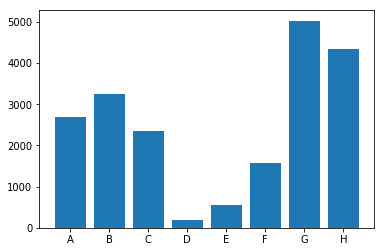

In [87]:
#plot distribution of sections
import matplotlib.pyplot as plt
plt.bar(range(len(Section_dict)), list(Section_dict.values()), align='center')
plt.xticks(range(len(Section_dict)), list(Section_dict.keys()))
plt.show()

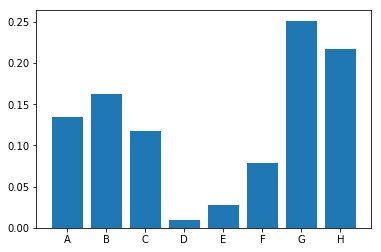

In [88]:
#plot relative distribution of sections
plt.bar(range(len(Section_dict)), np.array(list(Section_dict.values()))/len(labels_df), align='center')
plt.xticks(range(len(Section_dict)), list(Section_dict.keys()))
plt.show()

In [89]:
def to_multilabel_encode(features, labels, num_codes):
    """Input:
        features: list of the features
        labels: list of the labels associated with each feature in features, 
                wherein the labels are single uppercase letters from A to ...(defined by num_codes)
        num_codes: int, maximum number of codes
        Output:
            tuple of two numpy arrays, wherein the first array contains the features
            and the second array contains the corresponding features encoded in a "multi"-hot-encoding
    """
    assert len(labels) == len(features)
    assert num_codes > 0
    assert type(labels) == type([])
    assert type(features) == type([])
    features_final = []
    labels_final = []
    label_vector = np.zeros(num_codes)
    
    for index, feature in enumerate(features):
        if feature == None:
            pass #skipping missing abstracts
        else:
            if index == 0:
                try:
                    label_vector[ord(labels[index]) - 65] = 1
                except:
                    pass #skipping labels, which do not fit to the assumption of "uppercase letters from A ...(defined by num_codes)"
            else:
                if feature == features[index - 1]:
                    try:
                        label_vector[ord(labels[index]) - 65] = 1
                    except:
                        pass #skipping labels, which do not fit to the assumption of "uppercase letters from A ...(defined by num_codes)"
                else:
                    labels_final.append(label_vector)
                    features_final.append(features[index - 1])
                    label_vector = np.zeros(num_codes)
                    try:
                        label_vector[ord(labels[index]) - 65] = 1
                    except:
                        pass #skipping labels, which do not fit to the assumption of "uppercase letters from A ...(defined by num_codes)"

    labels_final.append(label_vector)
    features_final.append(features[-1])
    
    return (np.array(features_final), np.array(labels_final))

In [90]:
#turning the features and labels data frames to lists
features_list = features_df.tolist()
labels_list = labels_df.tolist()

In [93]:
#looking for None values (= missing abstracts) in the features list 
def look_for_None_values(list):
    sum_value = 0
    for index, element in enumerate(list):
        if element == None:
            sum_value += 1
            #print(index)

    print("None values in features list: ", sum_value)

look_for_None_values(features_list)

None values in features list:  0


In [92]:
#cleaning feature label pairs where the abstract in the features list is missing
features_cleaned = []
labels_cleaned = []
for index, element in enumerate(features_list):
    if element is not None:
        features_cleaned.append(element)
        labels_cleaned.append(labels_list[index])
features_list = features_cleaned[:]
labels_list = labels_cleaned[:]

In [94]:
#Looking for None values again
look_for_None_values(features_list)

None values in features list:  0


In [95]:
#Encoding
num_codes = 8
features_array, labels_array = to_multilabel_encode(features_list,labels_list, num_codes)

In [96]:
print(features_array.shape, labels_array.shape)

(19913,) (19913, 8)


In [97]:
#importing necessary tools
from keras.models import Model, Input
from keras.layers import Dense, Embedding, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences

In [100]:
#setting some variables
max_features = 40000  # number of words we want to keep
maxlen = 500  # max length of the abstract in the model
batch_size = 64  # batch size for the model
embedding_dims = 32  # dimension of the hidden variable, i.e. the embedding dimension

In [102]:
#shuffeling the data
indices = np.arange(features_array.shape[0])
np.random.shuffle(indices)
features_array = features_array[indices]
labels_array = labels_array[indices]

In [103]:
#splitting test and train data
X_train = features_array[0:len(features_array)//2]
X_test = features_array[len(features_array)//2:]

y_train = labels_array[0:len(labels_array)//2]
y_test = labels_array[len(labels_array)//2:]

In [104]:
#Tokenizing the data
tok = Tokenizer(num_words = max_features)
tok.fit_on_texts(X_train.tolist() + X_test.tolist())
x_train = tok.texts_to_sequences(X_train)
x_test = tok.texts_to_sequences(X_test)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')
print('Average train sequence length: {}'.format(np.mean(list(map(len, x_train)), dtype=int)))
print('Average test sequence length: {}'.format(np.mean(list(map(len, x_test)), dtype=int)))

9956 train sequences
9957 test sequences
Average train sequence length: 116
Average test sequence length: 115


In [105]:
#padding
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_train shape: (9956, 500)
x_test shape: (9957, 500)


In [106]:
#Defining the model
data_input = Input((maxlen,))

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
data_emb = Embedding(max_features, embedding_dims, input_length=maxlen, 
                        embeddings_initializer="uniform")(data_input)

# we add a GlobalMaxPooling1D, which will extract features from the embeddings
# of all words in the abstract
h = GlobalMaxPooling1D()(data_emb)

# We project onto a "num_codes"-unit output layer, and squash it with a sigmoid:
output = Dense(num_codes, activation='sigmoid')(h)

model = Model(inputs=data_input, outputs=output)

model.compile(loss='binary_crossentropy',
              optimizer=Adam(0.01),
              metrics=['accuracy'])

In [107]:
hist = model.fit(x_train, y_train, batch_size=batch_size, epochs=6, validation_split=0.1)


Train on 8960 samples, validate on 996 samples
Epoch 1/6
8960/8960 [==============================] - 8s 929us/step - loss: 0.3541 - acc: 0.8721 - val_loss: 0.2844 - val_acc: 0.8822
Epoch 2/6
8960/8960 [==============================] - 8s 849us/step - loss: 0.2673 - acc: 0.8891 - val_loss: 0.2616 - val_acc: 0.8927
Epoch 3/6
8960/8960 [==============================] - 8s 851us/step - loss: 0.2285 - acc: 0.9064 - val_loss: 0.2620 - val_acc: 0.8938
Epoch 4/6
8960/8960 [==============================] - 8s 858us/step - loss: 0.1929 - acc: 0.9248 - val_loss: 0.2694 - val_acc: 0.8929
Epoch 5/6
8960/8960 [==============================] - 8s 860us/step - loss: 0.1603 - acc: 0.9396 - val_loss: 0.2796 - val_acc: 0.8917
Epoch 6/6
8960/8960 [==============================] - 8s 861us/step - loss: 0.1325 - acc: 0.9527 - val_loss: 0.2993 - val_acc: 0.8891


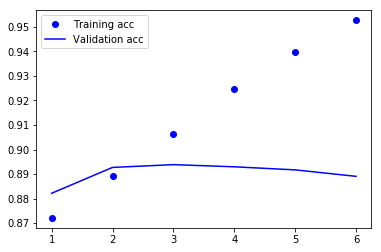

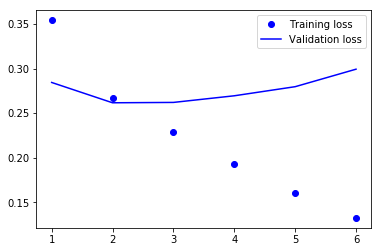

In [108]:
#Visualization
acc = hist.history['acc']
val_acc = hist.history['val_acc']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label ='Training acc')
plt.plot(epochs, val_acc, 'b', label ='Validation acc')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label ='Training loss')
plt.plot(epochs, val_loss, 'b', label ='Validation loss')
plt.legend()

plt.show()


Resources:
"Deep Learning with Python", Francois Chollet
https://www.depends-on-the-definition.com/guide-to-multi-label-classification-with-neural-networks/
https://www.depends-on-the-definition.com/classify-toxic-comments-on-wikipedia/